```sh
dvc exp run --queue \
    -S dataset.path='bdsaglam/musique-2hop' \
    -S qa.model='llama-3-70b-tgi' \
    -S qa.temperature='0.1' \
    -S qa.prompt='standard,cot-zs,cot-fs,cte' \
    -S run='1,2,3'
```

In [1]:
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
from bellem.dvc.experiment import load_experiments

experiments = load_experiments('prompt-comparison-2hop.json')
print(f"{len(experiments)} experiments")
experiments[0]

13 experiments


{'commit': 'workspace',
 'id': 'workspace',
 'name': None,
 'params': {'dataset': {'path': 'bdsaglam/musique-2hop',
   'name': 'answerable',
   'split': 'validation'},
  'qa': {'prompt': 'standard', 'model': 'llama-3-70b-tgi', 'temperature': 0.1},
  'run': 1},
 'metrics': {'exact_match': 0.5, 'f1': 0.6599999999999999, 'fuzzy_match': 0.7}}

In [3]:
df = pd.json_normalize(experiments).drop(columns=["commit", "id"])

param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop_duplicates(subset=param_cols, inplace=True)

mask = (df["params.dataset.path"] == "bdsaglam/musique-2hop") & (df["params.dataset.split"] == "validation")
df = df.loc[mask].reset_index(drop=True)
df = df.sort_values(
    [
        "params.dataset.path",
        "params.dataset.name",
        "params.dataset.split",
        "params.qa.model",
        "params.qa.prompt",
        "params.qa.temperature",
        "params.run",
    ]
)
df

,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.prompt,params.qa.model,params.qa.temperature,params.run,metrics.exact_match,metrics.f1,metrics.fuzzy_match
7,print-goos,bdsaglam/musique-2hop,answerable,validation,cot-fs,llama-3-70b-tgi,0.1,1,0.498403,0.582141,0.546326
4,salic-aril,bdsaglam/musique-2hop,answerable,validation,cot-fs,llama-3-70b-tgi,0.1,2,0.492812,0.577019,0.539137
2,curst-ones,bdsaglam/musique-2hop,answerable,validation,cot-fs,llama-3-70b-tgi,0.1,3,0.498403,0.582354,0.547923
8,ample-kifs,bdsaglam/musique-2hop,answerable,validation,cot-zs,llama-3-70b-tgi,0.1,1,0.495208,0.583063,0.543930
9,japan-sups,bdsaglam/musique-2hop,answerable,validation,cot-zs,llama-3-70b-tgi,0.1,2,0.503994,0.593333,0.553514
3,valid-shah,bdsaglam/musique-2hop,answerable,validation,cot-zs,llama-3-70b-tgi,0.1,3,0.504792,0.590520,0.550319
5,eerie-daff,bdsaglam/musique-2hop,answerable,validation,cte,llama-3-70b-tgi,0.1,1,0.652556,0.753282,0.707668
6,silly-pump,bdsaglam/musique-2hop,answerable,validation,cte,llama-3-70b-tgi,0.1,2,0.652556,0.754903,0.711661
1,mated-gray,bdsaglam/musique-2hop,answerable,validation,cte,llama-3-70b-tgi,0.1,3,0.657348,0.759364,0.718850
0,None,bdsaglam/musique-2hop,answerable,validation,standard,llama-3-70b-tgi,0.1,1,0.500000,0.660000,0.700000


In [5]:
# Average metrics over repeated runs (params.run)
df_avg = df.groupby(["params.qa.prompt"])[metric_cols].mean().loc[['standard', 'cot-zs', 'cot-fs', 'cte']].reset_index()
df_avg

,params.qa.prompt,metrics.exact_match,metrics.f1,metrics.fuzzy_match
0,standard,0.556976,0.680099,0.664643
1,cot-zs,0.501331,0.588972,0.549255
2,cot-fs,0.496539,0.580504,0.544462
3,cte,0.654153,0.755850,0.712726


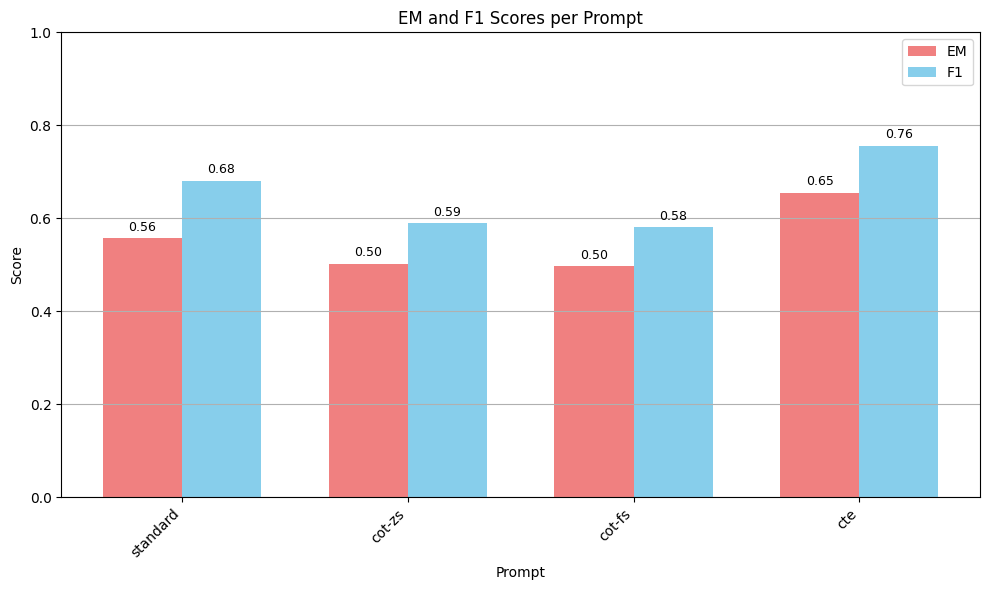

In [8]:
# Plotting EM and F1 scores together per prompt with temperature annotations
plt.figure(figsize=(10, 6))

# Create x-tick labels that include both the prompt and temperature
xs = df_avg['params.qa.prompt'].values

# Set the width for the bars and the positions
bar_width = 0.35
index = np.arange(len(xs))

# Plot Exact Match (EM) bars
bar1 = plt.bar(index, df_avg["metrics.exact_match"].values, bar_width, label="EM", color="lightcoral")

# Plot F1 bars, shifted by bar_width for side-by-side bars
bar2 = plt.bar(index + bar_width, df_avg["metrics.f1"].values, bar_width, label="F1", color="skyblue")

# Add labels and titles
plt.xlabel('Prompt')
plt.ylabel('Score')
plt.title('EM and F1 Scores per Prompt')

# Set x-ticks with prompt and temperature labels
plt.xticks(index + bar_width / 2, xs, rotation=45, ha='right')

# Add a legend to differentiate between EM and F1 scores
plt.legend()

# Add value labels on top of each EM bar
for bar in bar1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=9, color='black')

# Add value labels on top of each F1 bar
for bar in bar2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=9, color='black')

# Add a grid and display the plot
plt.grid(axis='y')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()